In [1]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from skimage import color

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if torch.cuda.is_available():
    print("CUDA is available. Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")


Using device: cuda
CUDA is available. Device: NVIDIA L4


In [ ]:
aquatic_defect_types = ['biofouling', 'holes', 'vegetation']
aquatic_defect_map = {'biofouling': 0, 'holes': 1, 'vegetation': 2}

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [4]:
class AquaticDefectDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path)
        if self.transform:
            image_tensor = self.transform(image)
        else:
            image_tensor = transforms.ToTensor()(image)
        return image_tensor, label


In [5]:
def load_and_split_images(data_path, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    train_data = []
    val_data = []
    test_data = []

    for aquatic_type in aquatic_defect_types:
        folder_path = os.path.join(data_path, aquatic_type)
        image_extensions = ['*.jpg', '*.jpeg']
        aquatic_images = []
        for ext in image_extensions:
            aquatic_images.extend(glob.glob(os.path.join(folder_path, ext)))

        aquatic_images = [(img_path, aquatic_defect_map[aquatic_type]) for img_path in aquatic_images]
        np.random.shuffle(aquatic_images)

        count = len(aquatic_images)
        train_count = int(train_ratio * count)
        val_count = int(val_ratio * count)

        train_data.extend(aquatic_images[:train_count])
        val_data.extend(aquatic_images[train_count:train_count + val_count])
        test_data.extend(aquatic_images[train_count + val_count:])

    return train_data, val_data, test_data


In [6]:
base_path_train = 'Data'

train_data, val_data, test_data = load_and_split_images(base_path_train)

print(f"Loaded {len(train_data)} training samples.")
print(f"Loaded {len(val_data)} validation samples.")
print(f"Loaded {len(test_data)} test samples.")


Loaded 1336 training samples.
Loaded 445 validation samples.
Loaded 447 test samples.


In [7]:
train_dataset = AquaticDefectDataset(train_data, transform=transform_train)
val_dataset = AquaticDefectDataset(val_data, transform=transform_val_test)
test_dataset = AquaticDefectDataset(test_data, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [8]:
def extract_manual_features(batch_images):
    batch_size = batch_images.size(0)
    manual_features = []

    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(batch_images.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(batch_images.device)
    denorm_images = batch_images * std + mean  

    for i in range(batch_size):
        img = denorm_images[i].cpu().numpy().transpose(1, 2, 0)  
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        hist_r = cv2.calcHist([img], [0], None, [64], [0,256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [64], [0,256]).flatten()
        hist_b = cv2.calcHist([img], [2], None, [64], [0,256]).flatten()
        color_hist = np.concatenate([hist_r, hist_g, hist_b])

        hog_features = hog(img_gray, pixels_per_cell=(32, 32), cells_per_block=(1, 1),
                           orientations=5, block_norm='L2-Hys', transform_sqrt=True,
                           feature_vector=True)
        
        pad_length =280-245 
        hog_features_reduced = np.pad(hog_features, (0,pad_length), 'constant')  
        
        lbp = local_binary_pattern(img_gray, P=16, R=2, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, 16 + 3),
                                     range=(0, 16 + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)

        edges = cv2.Canny(img_gray, 100, 200)
        edge_density = np.sum(edges) / (img_gray.shape[0] * img_gray.shape[1])

        features = np.concatenate([color_hist, hog_features_reduced, lbp_hist, [edge_density]]) 
        mean_gray = np.mean(img_gray)
        std_gray = np.std(img_gray)
        features = np.concatenate([features, [mean_gray, std_gray]]) 
        mean_r = np.mean(img[:,:,0])
        std_r = np.std(img[:,:,0])
        mean_g = np.mean(img[:,:,1])
        std_g = np.std(img[:,:,1])
        mean_b = np.mean(img[:,:,2])
        std_b = np.std(img[:,:,2])
        features = np.concatenate([features, [mean_r, std_r, mean_g, std_g, mean_b, std_b]])
        variance_gray = np.var(img_gray)
        features = np.concatenate([features, [variance_gray]])
        grad_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=5)
        grad_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=5)
        magnitude = cv2.magnitude(grad_x, grad_y)

        mag_hist = np.histogram(magnitude, bins=26, range=(0,256))[0]
        mag_hist = mag_hist.astype("float")
        mag_hist /= (mag_hist.sum() + 1e-7)

        features = np.concatenate([features, mag_hist])
        
        if len(features) != 526:
            print(f"Feature length mismatch: expected 526, got {len(features)} for image index {i}")
            raise ValueError("Manual feature extraction produced incorrect feature length.")

        manual_features.append(features)

    manual_features = np.array(manual_features, dtype=np.float32)

    manual_features = (manual_features - manual_features.mean(axis=0)) / (manual_features.std(axis=0) + 1e-7)
    manual_features = torch.tensor(manual_features, dtype=torch.float32).to(batch_images.device)

    return manual_features


In [9]:
class CrackDetectionModel(nn.Module):
    def __init__(self, num_classes, manual_feature_dim):
        super(CrackDetectionModel, self).__init__()

        self.efficient_net = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficient_net.classifier = nn.Identity()
        self.efficient_dim = 1280

        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()
        self.resnet_dim = 2048

        self.senet = timm.create_model('seresnet50', pretrained=True, num_classes=0)
        self.senet_dim = self.senet.num_features 

        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.vit_dim = self.vit.embed_dim  

        self.manual_feature_dim = manual_feature_dim  

        self.total_feature_dim = self.efficient_dim + self.resnet_dim + self.senet_dim + self.vit_dim + self.manual_feature_dim  # 1280 + 2048 + 2048 + 768 + 526 = 5670

        self.layer_norm = nn.LayerNorm(self.total_feature_dim)

        self.attention = nn.Sequential(
            nn.Linear(self.total_feature_dim, self.total_feature_dim),
            nn.Tanh(),
            nn.Linear(self.total_feature_dim, self.total_feature_dim),
            nn.Softmax(dim=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.total_feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, manual_features):
        x_efficient = self.efficient_net(x)
        x_resnet = self.resnet(x)
        x_senet = self.senet(x)
        x_vit = self.vit.forward_features(x) 
        x_vit = x_vit[:, 0, :] 

        combined_features = torch.cat([x_efficient, x_resnet, x_senet, x_vit, manual_features], dim=1) 
        combined_features = self.layer_norm(combined_features) 
        attention_weights = self.attention(combined_features) 
        weighted_features = combined_features * attention_weights 
        outputs = self.classifier(weighted_features)
        return outputs


Epoch 1/30 - Train Loss: 0.8701, Train Acc: 0.5883, Val Loss: 0.5217, Val Acc: 0.8472
Epoch 2/30 - Train Loss: 0.4096, Train Acc: 0.8975, Val Loss: 0.3170, Val Acc: 0.9281
Epoch 3/30 - Train Loss: 0.3402, Train Acc: 0.9072, Val Loss: 0.2592, Val Acc: 0.9326
Epoch 4/30 - Train Loss: 0.2554, Train Acc: 0.9222, Val Loss: 0.1828, Val Acc: 0.9506
Epoch 5/30 - Train Loss: 0.2047, Train Acc: 0.9416, Val Loss: 0.2663, Val Acc: 0.9169
Epoch 6/30 - Train Loss: 0.2431, Train Acc: 0.9177, Val Loss: 0.1576, Val Acc: 0.9551
Epoch 7/30 - Train Loss: 0.2622, Train Acc: 0.9184, Val Loss: 0.1742, Val Acc: 0.9348
Epoch 8/30 - Train Loss: 0.2143, Train Acc: 0.9311, Val Loss: 0.1917, Val Acc: 0.9326
Epoch 9/30 - Train Loss: 0.2010, Train Acc: 0.9341, Val Loss: 0.1588, Val Acc: 0.9528
Epoch 10/30 - Train Loss: 0.1642, Train Acc: 0.9454, Val Loss: 0.1298, Val Acc: 0.9506
Epoch 11/30 - Train Loss: 0.1817, Train Acc: 0.9379, Val Loss: 0.1694, Val Acc: 0.9348
Epoch 12/30 - Train Loss: 0.1584, Train Acc: 0.9454,

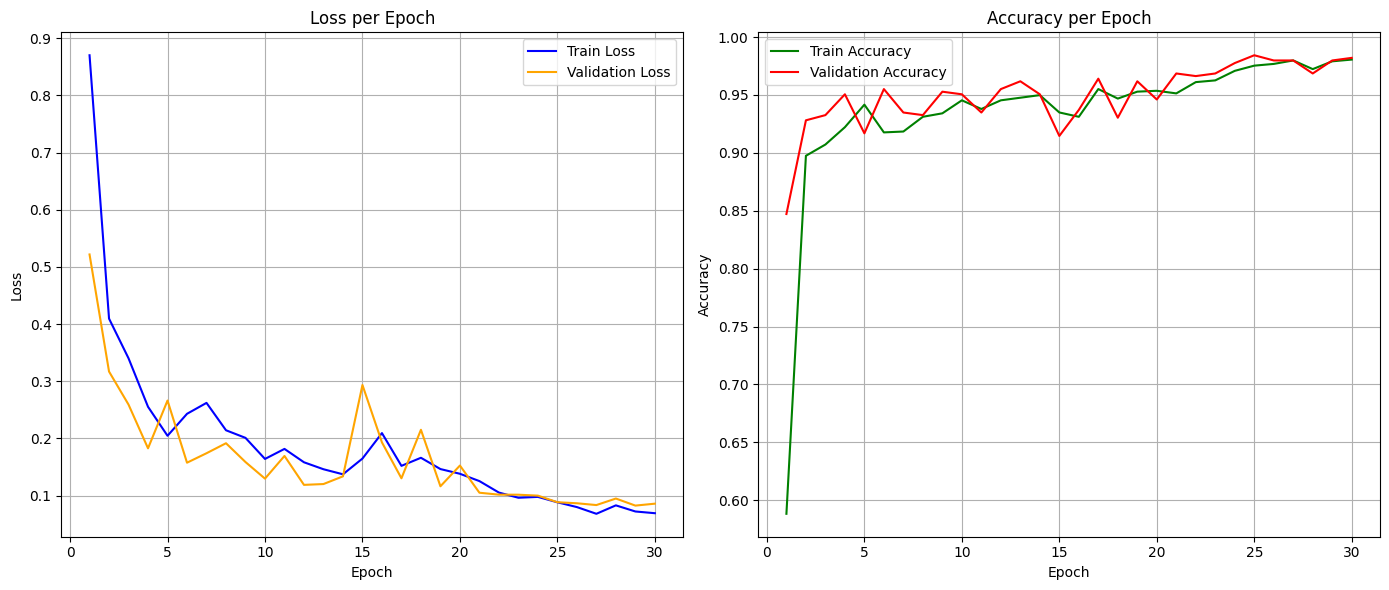

In [10]:
num_classes = 3
manual_feature_dim = 526 
model = CrackDetectionModel(num_classes, manual_feature_dim)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
num_epochs = 30

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        manual_features = extract_manual_features(images) 
        optimizer.zero_grad()
        
        outputs = model(images, manual_features) 
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_predictions.double() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())

    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            manual_features = extract_manual_features(images) 
            outputs = model(images, manual_features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct_predictions += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct_predictions.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'prob2_weights_epoch_{epoch+1}.pth')

print("Training complete.")

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
model_path = "prob2_weights_epoch_30.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

def evaluate_metrics(model, test_loader, num_classes=3):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            manual_features = extract_manual_features(images)

            outputs = model(images, manual_features)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=list(range(num_classes)))
    avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    iou = []
    for cls in range(num_classes):
        tp = np.sum((all_preds == cls) & (all_labels == cls))
        fp = np.sum((all_preds == cls) & (all_labels != cls))
        fn = np.sum((all_preds != cls) & (all_labels == cls))
        cls_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        iou.append(cls_iou)
    avg_iou = np.mean(iou)

    metrics = {
        'overall_accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'IoU_per_class': iou,
        'average_precision': avg_precision,
        'average_recall': avg_recall,
        'average_f1': avg_f1,
        'average_IoU': avg_iou
    }

    return metrics

metrics = evaluate_metrics(model, test_loader, num_classes=3)
print(f"Evaluation Metrics:")
print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
for cls, defect in enumerate(aquatic_defect_types):
    print(f"Class '{defect}':")
    print(f"Precision: {metrics['precision_per_class'][cls]:.4f}")
    print(f"Recall: {metrics['recall_per_class'][cls]:.4f}")
    print(f"F1 Score: {metrics['f1_per_class'][cls]:.4f}")
    print(f"IoU: {metrics['IoU_per_class'][cls]:.4f}")
    
print(f"Average Precision: {metrics['average_precision']:.4f}")
print(f"Average Recall: {metrics['average_recall']:.4f}")
print(f"Average F1 Score: {metrics['average_f1']:.4f}")
print(f"Average IoU: {metrics['average_IoU']:.4f}")


<ipython-input-12-0a27ace99fba>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluation Metrics:
  Overall Accuracy: 0.9843
  Class 'biofouling':
    Precision: 1.0000
    Recall:    0.9712
    F1 Score:  0.9854
    IoU:       0.9712
  Class 'holes':
    Precision: 0.9625
    Recall:    0.9625
    F1 Score:  0.9625
    IoU:       0.9277
  Class 'vegetation':
    Precision: 0.9828
    Recall:    1.0000
    F1 Score:  0.9913
    IoU:       0.9828
  Average Precision: 0.9818
  Average Recall:    0.9779
  Average F1 Score:  0.9797
  Average IoU:       0.9606
